In [1]:
import time
import math
import numpy as np
import rtde.rtde as rtde
import rtde.rtde_config as rtde_config
from roboticstoolbox import models
from spatialmath import SE3
from spatialmath.base import angvec2tr


In [2]:
def axis_angle_to_transform(tcp_pose):
    """
    Convert a UR axis-angle TCP pose to a 4x4 transformation matrix.
    UR TCP pose is [x, y, z, Rx, Ry, Rz], where (Rx, Ry, Rz) is axis-angle.
    """
    x, y, z, Rx, Ry, Rz = tcp_pose
    angle = np.linalg.norm([Rx, Ry, Rz])
    
    # Build the rotation matrix from axis-angle
    if angle < 1e-12:
        # Very small angle => no rotation
        rot_mat = np.eye(4)
    else:
        axis = [Rx/angle, Ry/angle, Rz/angle]
        rot_mat = angvec2tr(angle, axis)
    
    # Set the translation part
    rot_mat[0, 3] = x
    rot_mat[1, 3] = y
    rot_mat[2, 3] = z
    
    return rot_mat


In [22]:
# RTDE connection parameters
ROBOT_IP = "192.168.200.10"  # Replace with your UR5's IP address
PORT = 30004                 # Default RTDE port for UR robots

# Load the RTDE configuration (ensure your XML outputs joint angles & TCP pose)
conf = rtde_config.ConfigFile(r"./RTDE_Python_Client_Library/examples/record_configuration.xml")
output_names, output_types = conf.get_recipe("out")

# Establish RTDE connection to the UR5
con = rtde.RTDE(ROBOT_IP, PORT)
con.connect()
con.send_output_setup(output_names, output_types)
con.send_start()

# Use the built-in UR5 model from the Robotics Toolbox for Python
ur5 = models.DH.UR5()

# Example tool offset: Suppose the tool is 0.15 m along the Z-axis from the UR5 flange.
# Adjust these values to match your actual tool geometry.
tool_offset = SE3(0, 0, 0.15)
ur5.tool = tool_offset  # Incorporate this offset into forward kinematics

print("Connected to UR5. Retrieving joint angles and computing forward kinematics...\n")

# Receive one state from the RTDE
state = con.receive()
if state:
    # 1) Joint angles (in radians)
    q = state.actual_q
    print("Joint angles:", q)

    # 2) Robot-reported TCP pose ([x, y, z, Rx, Ry, Rz] in axis-angle)
    tcp_pose = state.actual_TCP_pose
    print("Robot-reported TCP pose (axis-angle):", tcp_pose)

    # Convert to a 4x4 transformation matrix
    T_robot_reported = axis_angle_to_transform(tcp_pose)
    print("\nRobot-reported Transformation Matrix (Base to TCP):")
    print(T_robot_reported)

    # 3) Compute forward kinematics with tool offset included
    T_dh = ur5.fkine(q)  # This now includes the tool transform (ur5.tool)
    print("\nDH-based FK (with tool offset) from joint angles:")
    print(T_dh)

    # Cleanup
    con.disconnect()


Connected to UR5. Retrieving joint angles and computing forward kinematics...

Joint angles: [0.7267194390296936, -1.942333837548727, -2.0496392250061035, -2.273778577844137, -0.8829587141620081, 2.369927406311035]
Robot-reported TCP pose (axis-angle): [0.6997228207865462, 0.18818288427348978, 0.17007950849059322, -1.7329295376988552, 0.6949529499305291, -1.7307409747223876]

Robot-reported Transformation Matrix (Base to TCP):
[[ 0.0191002   0.04184302  0.99894161  0.69972282]
 [-0.72105986 -0.69155242  0.04275428  0.18818288]
 [ 0.69260946 -0.72111331  0.01696254  0.17007951]
 [ 0.          0.          0.          1.        ]]

DH-based FK (with tool offset) from joint angles:
   0.01883   0.0365    0.9992    0.6146    
  -0.7242   -0.6885    0.03879   0.203     
   0.6893   -0.7244    0.01347   0.09917   
   0         0         0         1         



In [17]:
print(ur5)

DHRobot: UR5 (by Universal Robotics), 6 joints (RRRRRR), dynamics, standard DH parameters
┌─────┬─────────┬─────────┬────────┐
│ θⱼ  │   dⱼ    │   aⱼ    │   ⍺ⱼ   │
├─────┼─────────┼─────────┼────────┤
│  q1 │ 0.08946 │       0 │  90.0° │
│  q2 │       0 │  -0.425 │   0.0° │
│  q3 │       0 │ -0.3922 │   0.0° │
│  q4 │  0.1091 │       0 │  90.0° │
│  q5 │ 0.09465 │       0 │ -90.0° │
│  q6 │  0.0823 │       0 │   0.0° │
└─────┴─────────┴─────────┴────────┘

┌──────┬──────────────────────────────────────┐
│ tool │ t = 0, 0, 0.15; rpy/xyz = 0°, 0°, 0° │
└──────┴──────────────────────────────────────┘

┌──────┬───────┬─────┬─────┬─────┬──────┬─────┐
│ name │ q0    │ q1  │ q2  │ q3  │ q4   │ q5  │
├──────┼───────┼─────┼─────┼─────┼──────┼─────┤
│   qr │  180° │  0° │  0° │  0° │  90° │  0° │
│   qz │  0°   │  0° │  0° │  0° │  0°  │  0° │
└──────┴───────┴─────┴─────┴─────┴──────┴─────┘



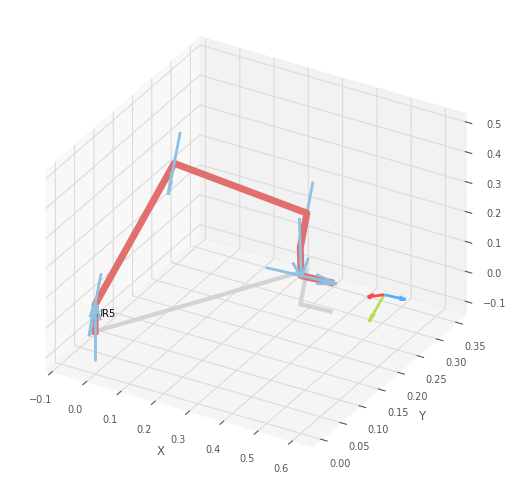

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'UR5')

<Figure size 640x480 with 0 Axes>

In [18]:
ur5.plot(q)  # Visualize the UR5 in the given joint configuration